In [42]:
# This dataset has 2 outputs bro that's why we are using functional model

import os 
import numpy as np 
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [43]:
folder_path = r"C:\Users\chatt\Desktop\DL Tutorials\Functional Model\Dataset\UTKFace"


In [44]:
age = []
gender = []
img_path = []

for file in os.listdir(folder_path):
    age.append(int(file.split('_')[0]))
    gender.append(int(file.split('_')[1]))
    img_path.append(file)

In [45]:
len(age)

23708

In [46]:
df =  pd.DataFrame({'age':age , 'gender':gender , 'img':img_path})


In [47]:
df.shape

(23708, 3)

In [48]:
df.head()

,age,gender,img
0,100,0,100_0_0_20170112213500903.jpg.chip.jpg
1,100,0,100_0_0_20170112215240346.jpg.chip.jpg
2,100,1,100_1_0_20170110183726390.jpg.chip.jpg
3,100,1,100_1_0_20170112213001988.jpg.chip.jpg
4,100,1,100_1_0_20170112213303693.jpg.chip.jpg


In [49]:
train_df = df.sample(frac=1 , random_state=0).iloc[:20000]
test_df = df.sample(frac=1 , random_state=0).iloc[20000:]

In [50]:
train_df.shape

(20000, 3)

In [51]:
test_df.shape

(3708, 3)

In [52]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [63]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=folder_path,
    x_col='img',  # column with image filenames
    y_col=['age', 'gender'],  # columns with labels (age and gender)
    target_size=(200, 200),  # resizing images to this size
    class_mode='raw',  # 'raw' because we have multiple custom labels (age and gender)
    batch_size=32
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=folder_path,
    x_col='img',  # column with image filenames
    y_col=['age', 'gender'],  # columns with labels (age and gender)
    target_size=(200, 200),  # resizing images to this size
    class_mode='raw',  # 'raw' because we have multiple custom labels (age and gender)
    batch_size=32
)


Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [64]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [65]:
vggnet = VGG16(include_top=False , input_shape=(200 , 200 , 3))

In [74]:

# Load pre-trained VGG16 model (without the top classification layers)
vggnet = VGG16(include_top=False, weights='imagenet', input_shape=(200, 200, 3))

# Freeze VGGNet layers
vggnet.trainable = False

# Get the output of the last layer of VGGNet
output = vggnet.output

# Flatten the output to feed into dense layers
flatten = Flatten()(output)

# Independent Dense layers
dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512, activation='relu')(flatten)

# Merge dense1 and dense2 (concatenate)
merged = concatenate([dense1, dense2])

# Additional dense layers after merge
dense3 = Dense(512, activation='relu')(merged)
dense4 = Dense(512, activation='relu')(merged)

# Output layers for age and gender prediction
output1 = Dense(1, activation='linear', name='age')(dense3)   # Regression for age
output2 = Dense(1, activation='sigmoid', name='gender')(dense4)  # Binary classification for gender


In [75]:
model = Model(inputs= vggnet.input , outputs=[output1 , output2])

In [76]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 200, 200,  │      1,792 │ input_layer_5[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 200, 200,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 100, 100,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 100, 100,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 100, 100,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 50, 50,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 50, 50,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 50, 50,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 50, 50,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 25, 25,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 25, 25,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 25, 25,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 25, 25,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 12, 12,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 12, 12,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 12, 12,    │  2,359,808 │ block5_conv1[0][

 Total params: 34,640,706 (132.14 MB)

 Trainable params: 19,926,018 (76.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

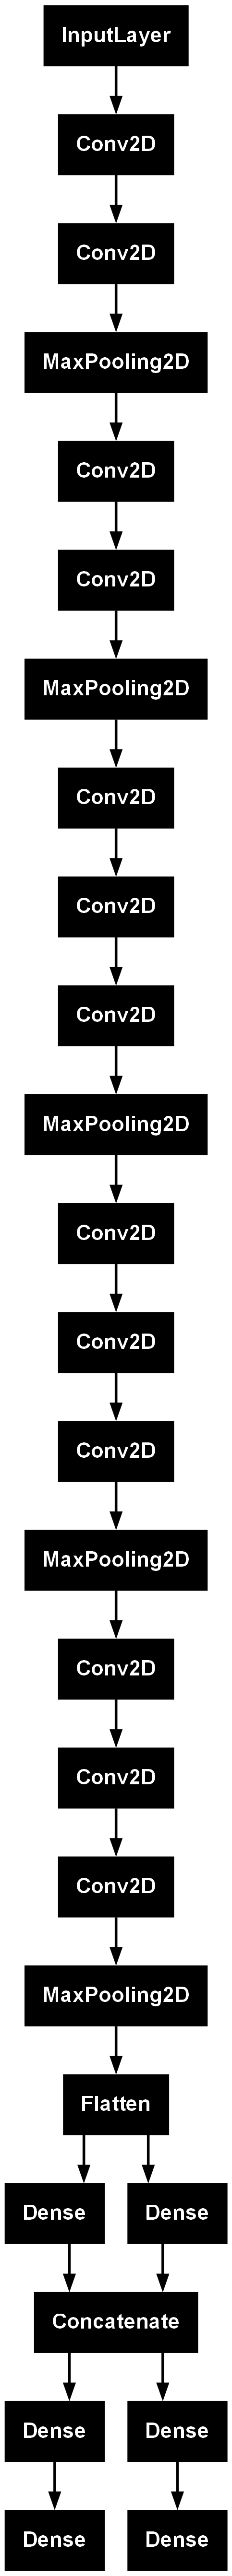

In [77]:
from keras.utils import plot_model
plot_model(model)

In [78]:
model.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'},loss_weights={'age':1,'gender':99})